# **Analyse Exploratoire : Building Energy Benchmarking (Seattle)**

Le dataset utilisé est [téléchargeable ici](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv).
<br><br>
La définition des variables est [disponible ici](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy).
<br><br>
*Le programme de mesure et de déclaration de la consommation d'énergie des bâtiments de Seattle (SMC 22.920) exige des propriétaires de bâtiments non résidentiels et multifamiliaux (de 20 000 pieds carrés ou plus) de suivre les performances énergétiques et de les déclarer chaque année à la ville de Seattle. Les bâtiments représentent 33 % des émissions principales de Seattle. La politique de mesure d'évaluation soutient les objectifs de Seattle visant à réduire la consommation d'énergie et les émissions de gaz à effet de serre des bâtiments existants. En 2013, la ville de Seattle a adopté un plan d'action climatique pour atteindre zéro émission nette de gaz à effet de serre d'ici 2050. La mesure, la déclaration annuelle et la divulgation des performances des bâtiments sont des éléments fondamentaux pour créer une valeur marchande plus élevée pour l'efficacité énergétique.*
<br><br>
**Ces données concernent uniquement l'année 2016.**
<br><br>
*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1)*

In [1]:
# Bibliothèques de base
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Utilisés lors de l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Servira pour faire l'ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Pour faire tests de normalité
from scipy.stats import shapiro

# Je désactive le copy warning, en m'étant au préalable assuré que les traitements étaient corrects
pd.options.mode.chained_assignment = None  # default='warn'

## **Importation du dataset**

In [2]:
data_raw = pd.read_csv("2016_Building_Energy_Benchmarking.csv", sep=',')
print('Importation terminée')

Importation terminée


## **Premier aperçu du dataset**

In [3]:
print("Premières lignes : ")
display(data_raw.head())

print("Résumé des valeurs numériques : ")
display(data_raw.describe())

print("- Le dataset contient", data_raw.shape[0], "lignes et", data_raw.shape[1], "colonnes.")
print("- Il y a", data_raw.duplicated().sum(), "lignes en doubles.")

colonnes_vides = data_raw.columns[data_raw.nunique() == 0]
print("-", len(colonnes_vides), "colonnes du dataset sont entièrement vides :", colonnes_vides.tolist())

print()

data_raw.info(verbose = True)

Premières lignes : 


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Résumé des valeurs numériques : 


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,...,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,...,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,...,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,...,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,...,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,...,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


- Le dataset contient 3376 lignes et 46 colonnes.
- Il y a 0 lignes en doubles.
- 1 colonnes du dataset sont entièrement vides : ['Comments']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  C

## **Fonction de représentation du niveau de remplissage du dataset**

In [4]:
def filling_level(dataset=data_raw):

    ####################################################################
    # Graphique montrant les pourcentages de vide pour chaque colonnes #
    ####################################################################

    dataset_a_utiliser = dataset

    # Si le dataset est totalement plein, pas la peine d'afficher ce graphique, qui serait totalement vide
    if dataset_a_utiliser.isna().sum().sum() != 0:

        colonnes_incompletes = dataset_a_utiliser.isna().mean()

        fig, ax = plt.subplots(figsize=(30,10))

        # Création d'une palette personnalisée
        colors = [{p<0.5: '#3A923A', 0.3<=p<=0.5: '#E1812C', p>0.5: '#C03D3E'}[True] for p in colonnes_incompletes.values.tolist()]
        sns.set_palette(sns.color_palette(colors))

        sns.barplot(x=colonnes_incompletes.index, y=colonnes_incompletes.values*100, alpha = 0.9)

        plt.xticks(rotation=90)
        ax.set_title('\nPourcentage de valeurs manquantes dans les différentes colonnes\n', fontsize='xx-large')
        ax.set_ylabel('Valeurs manquantes (%)', fontsize='x-large')

        plt.show()
    else:
        print("Ce dataset ne contient aucune valeur manquante.")

    ###########################################################
    # Diagramme en secteurs pour la répartition vide/non vide #
    ###########################################################

    # Si le dataset est totalement plein, pas la peine d'afficher ce diagramme, qui ne contiendrait qu'une seule valeur.
    if dataset_a_utiliser.isna().sum().sum() != 0:
        vide = dataset_a_utiliser.isnull().sum().sum() # Somme de la somme des NaN de chaque colonne
        plein = dataset_a_utiliser.notnull().sum().sum() # Somme de la somme des non NaN de chaque colonne

        labels = 'Plein', 'Vide'
        sizes = [plein, vide]

        colors=['#FFB2B2', '#B2B2FF']

        fig, ax = plt.subplots(figsize=(10, 10))
        plt.title("\nRemplissage du dataframe", fontsize=30)
        ax.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%', colors=colors, textprops={'color':"black", 'fontsize':25});
        plt.show()

        print("Il y a", len(colonnes_incompletes[colonnes_incompletes.values > 0.5]), "colonnes avec plus de 50 % de données manquantes.\n\n")


    ####################################################################
    # Diagramme en secteurs pour la répartition quantitatif/qualitatif #
    ####################################################################

    colonne_numeriques = dataset_a_utiliser.select_dtypes(np.number).shape[1]
    autres_colonnes = dataset_a_utiliser.shape[1] - dataset_a_utiliser.select_dtypes(np.number).shape[1]

    labels = 'Quantitatives', 'Qualitatives'
    sizes = [colonne_numeriques, autres_colonnes]

    colors=['#FFB2B2', '#B2B2FF']

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("\nRépartition du type de variable", fontsize=30)
    ax.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%', colors=colors, textprops={'color':"black", 'fontsize':25});
    plt.show()

    print("Variables quantitatives :", colonne_numeriques)
    print("Variables qualitatives :", autres_colonnes)
    print("Total des variables :", dataset_a_utiliser.shape[1])

## **Représentation du remplissage du dataset**

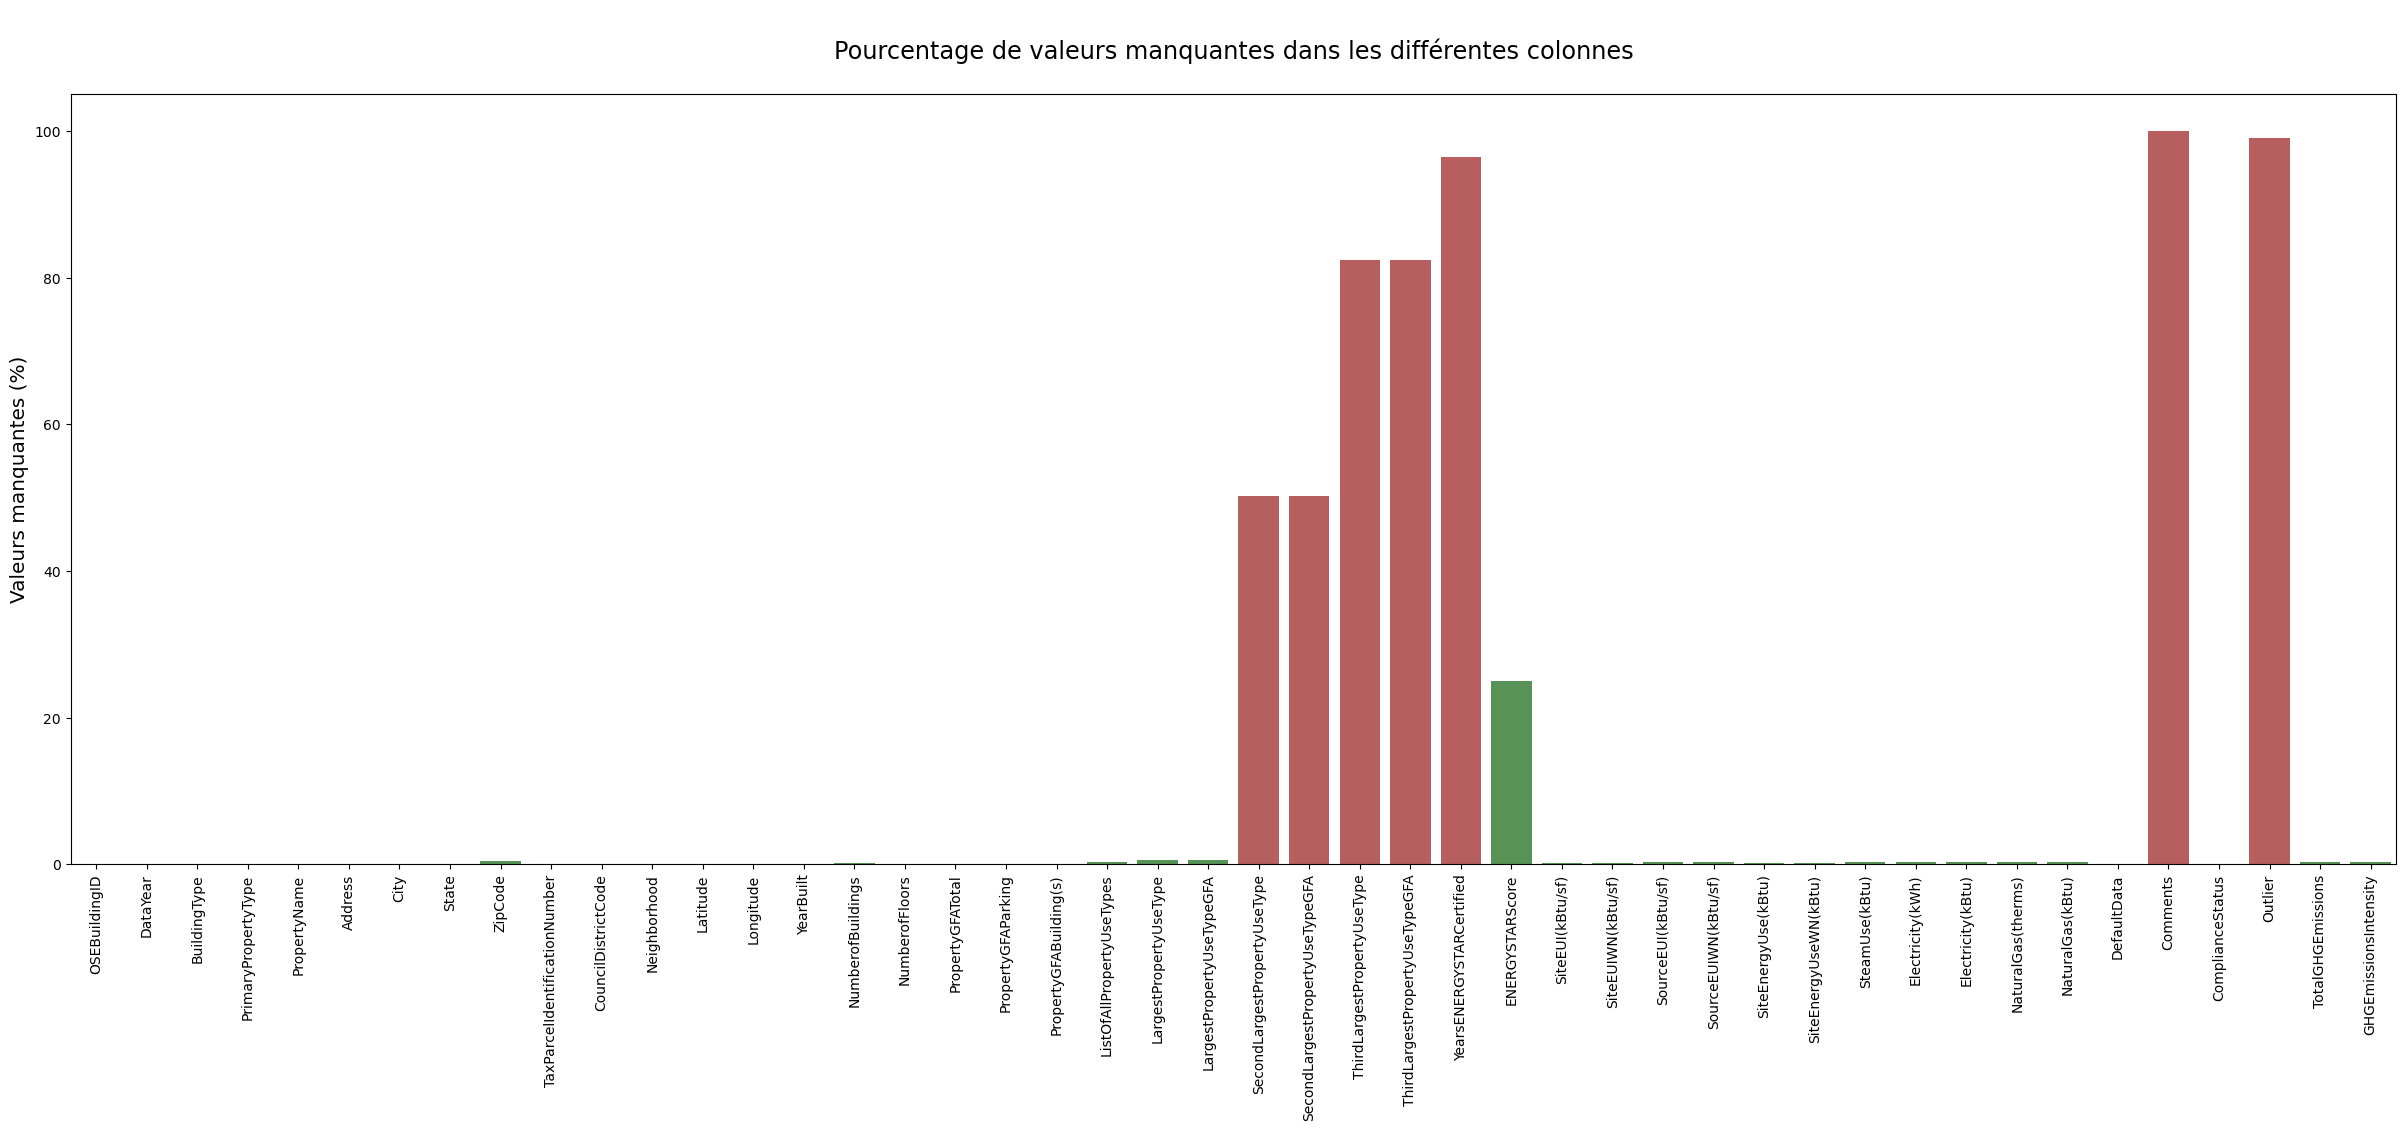

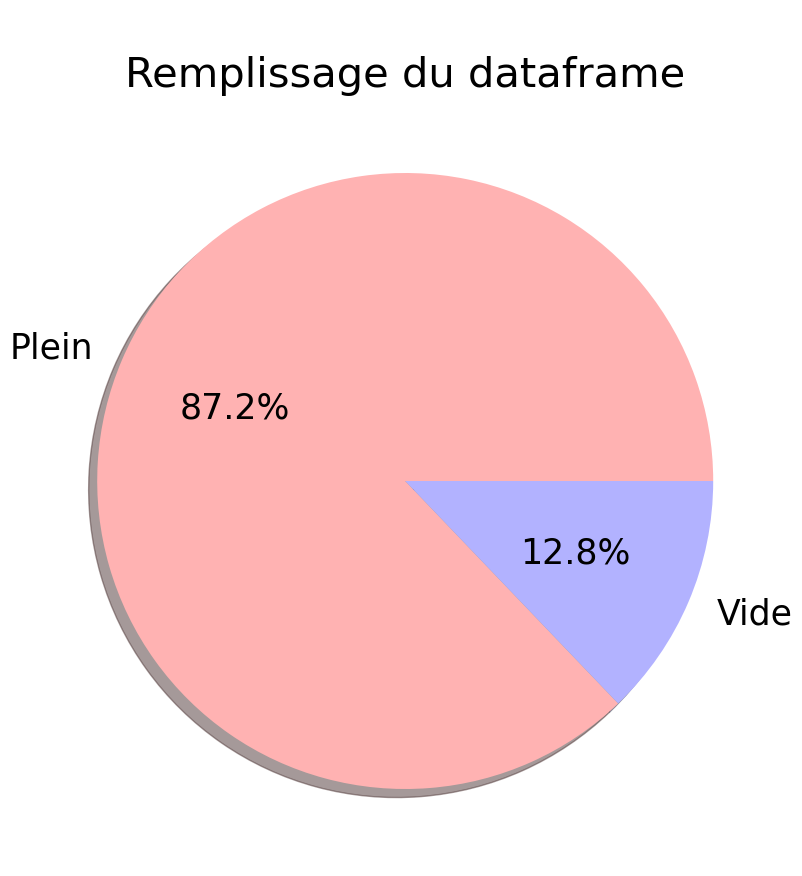

Il y a 7 colonnes avec plus de 50 % de données manquantes.




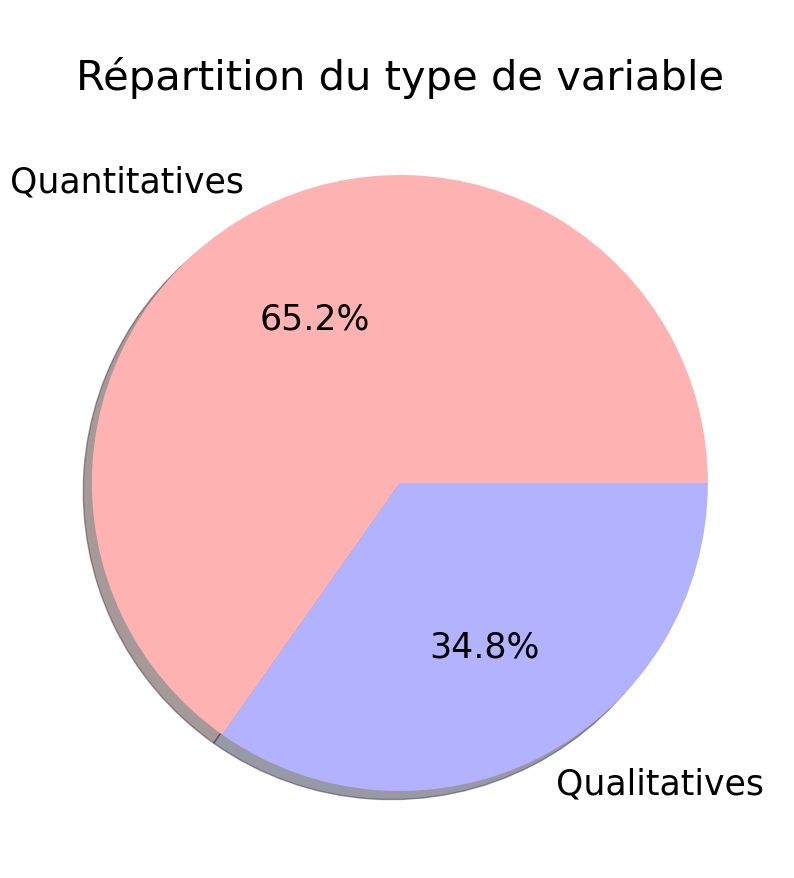

Variables quantitatives : 30
Variables qualitatives : 16
Total des variables : 46


In [5]:
filling_level(dataset=data_raw)

# **Nettoyage du dataset**

### **Traitement de la variable *OSEBuildingID***

In [6]:
print("Il y a", data_raw['OSEBuildingID'].isnull().sum(), "valeurs nulles dans la colonne OSEBuildingID.")

# Suppression des lignes où 'OSEBuildingID' est NaN
if data_raw['OSEBuildingID'].isnull().sum() > 0:
    data_raw = data_raw[data_raw['OSEBuildingID'].notna()]
    print("Valeurs nulles supprimées.")

print("Il y a", data_raw['OSEBuildingID'].duplicated().sum(), "doubles dans la colonne OSEBuildingID")

Il y a 0 valeurs nulles dans la colonne OSEBuildingID.
Il y a 0 doubles dans la colonne OSEBuildingID


### **Sélection des bâtiments non résidentiels uniquement**

Comme demandé dans les consignes du projet.<br>
Autrement dit, je supprime les lignes dont à variable *BuildingType* est *Multifamily MR (5-9)*, *Multifamily LR (1-4)* ou *Multifamily HR (10+)*.

In [7]:
print("Nombre d'entrées avant suppression des bâtiments résidentiels :", data_raw.shape[0])

data_raw = data_raw.loc[(data_raw['BuildingType'] != 'Multifamily MR (5-9)') & (data_raw['BuildingType'] != 'Multifamily LR (1-4)') & (data_raw['BuildingType'] != 'Multifamily HR (10+)')]

print("Nombre d'entrées après suppression des bâtiments résidentiels :", data_raw.shape[0])

Nombre d'entrées avant suppression des bâtiments résidentiels : 3376
Nombre d'entrées après suppression des bâtiments résidentiels : 1668


### **Traitement des bâtiments qui n'ont pas satisfait les exigences de mesure**

Je me base sur la variable *ComplianceStatus* et ne conserve que les entrées *"Compliant"*.

In [8]:
print("Nombre d'entrées avant suppression des bâtiments non Compliant :", data_raw.shape[0])

data_raw = data_raw.loc[data_raw['ComplianceStatus'] == "Compliant"]

print("Nombre d'entrées après suppression des bâtiments non Compliant :", data_raw.shape[0])

Nombre d'entrées avant suppression des bâtiments non Compliant : 1668
Nombre d'entrées après suppression des bâtiments non Compliant : 1548


### **Sélection des colonnes qui nous intéressent**

In [9]:
colonnes_a_garder = [
                    'BuildingType',
                    'PrimaryPropertyType',
                    'Neighborhood',
                    'YearBuilt',
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'ENERGYSTARScore',
                    'SiteEnergyUseWN(kBtu)',
                    'TotalGHGEmissions'
                    ]
print("Variables conservées :", colonnes_a_garder)

colonnes_non_gardees = [x for x in data_raw.columns if x not in colonnes_a_garder]
print("Variables non conservées :", colonnes_non_gardees)

print("Nombre de variables avant traiement :", data_raw.shape[1])
data_clean = data_raw[colonnes_a_garder]
print("Nombre de variables après traiement :", data_clean.shape[1])




Variables conservées : ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
Variables non conservées : ['OSEBuildingID', 'DataYear', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'PropertyGFATotal', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']
Nomb

### **Traitement du type des variables**

In [10]:
print("Type des différentes variables :")
data_clean.dtypes

Type des différentes variables :


BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
ENERGYSTARScore           float64
SiteEnergyUseWN(kBtu)     float64
TotalGHGEmissions         float64
dtype: object

*NumberofBuildings* et *ENERGYSTARScore* sont des variables quantitatives discrètes.<br>
Je vais passer leur type en *Int64*

In [11]:
data_clean = data_clean.astype({'NumberofBuildings': 'Int64', 'ENERGYSTARScore': 'Int64'})

Pas de problème pour les autres variables.

### **Valeurs nulles**

In [12]:
data_clean.isnull().sum()

BuildingType                0
PrimaryPropertyType         0
Neighborhood                0
YearBuilt                   0
NumberofBuildings           0
NumberofFloors              0
PropertyGFAParking          0
PropertyGFABuilding(s)      0
ENERGYSTARScore           551
SiteEnergyUseWN(kBtu)       1
TotalGHGEmissions           0
dtype: int64

- Je supprime les entrées où *SiteEnergyUseWN(kBtu)* est vide car c'est une de nos variables cibles.

In [13]:
print("Nombre d'entrées avant suppression des valeurs nulles dans SiteEnergyUseWN(kBtu) :", data_clean.shape[0])

data_clean = data_clean.loc[data_clean['SiteEnergyUseWN(kBtu)'].isnull() == False]

print("Nombre d'entrées après suppression des bâtiments résidentiels :", data_clean.shape[0])

Nombre d'entrées avant suppression des valeurs nulles dans SiteEnergyUseWN(kBtu) : 1548
Nombre d'entrées après suppression des bâtiments résidentiels : 1547


- Pour la variable *ENERGYSTARScore*, il y a trop de données manquantes (environ 30 %), je vais traitrer ça après.

### **Valeurs aberrantes**

- *'Low-Rise Multifamily'* (variable *PrimaryPropertyType*) : je supprime les entrées concernées, car on est sensé ne pas avoir de bâtiments résidentiels.

In [14]:
print("Nombre d'entrées avant suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) :", data_clean.shape[0])

data_clean = data_clean.loc[data_clean['PrimaryPropertyType'] != 'Low-Rise Multifamily']

print("Nombre d'entrées après suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) :", data_clean.shape[0])

Nombre d'entrées avant suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) : 1547
Nombre d'entrées après suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) : 1545


- *Neighborhood* : j'uniformise

In [15]:
data_clean['Neighborhood'] = data_clean['Neighborhood'].str.upper()
data_clean['Neighborhood'].loc[data_clean['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS'] = 'DELRIDGE'

- *NumberofBuildings* : quand c'est égal à 0, je présume que ça n'a pas été renseigné car il n'y avait qu'un bâtiment. Donc je change la valeur à 1.<br>
Il y a également des valeurs assez élevées, mais il s'agit de campus : atypique, mais pas aberrant.

In [16]:
data_clean['NumberofBuildings'].loc[data_clean['NumberofBuildings'] == 0] = 1

- *SiteEnergyUseWN(kBtu)* : quand c'est égal à 0, c'est aberrant, je supprime les entrées concernées.

In [17]:
data_clean = data_clean.loc[data_clean['SiteEnergyUseWN(kBtu)'] != 0]

- *NumberofFloors* : je supprime les valeurs supérieures à 90 et je mets les valeurs égales à 0 à 1.

In [18]:
data_clean = data_clean.loc[data_clean['NumberofFloors'] < 90]
data_clean['NumberofFloors'].loc[data_clean['NumberofFloors'] == 0] = 1


### **Cas de la variable *ENERGYSTARScore***

Pour la variable *ENERGYSTARScore*, puisqu'il y a trop de données manquantes (environ 30 %) pour pouvoir les imputer correctement, je vais séparer en deux datasets : <br>
- un avec *ENERGYSTARScore* où je supprime toutes les entrées nulles pour cette variable
- un où je supprime la variable *ENERGYSTARScore*

In [19]:
data_clean_score = data_clean.loc[data_clean['ENERGYSTARScore'].isnull() == False]
print("Création du dataset 'data_clean_score'. Nombre d'entrées dans ce dataset :", data_clean_score.shape[0])

data_clean = data_clean.drop(columns=['ENERGYSTARScore'])
print("Variable 'ENERGYSTARScore' supprimée du dataset 'data_clean'.")

Création du dataset 'data_clean_score'. Nombre d'entrées dans ce dataset : 988
Variable 'ENERGYSTARScore' supprimée du dataset 'data_clean'.


### **Représentation du remplissage du dataset après nettoyage**

Ce dataset ne contient aucune valeur manquante.


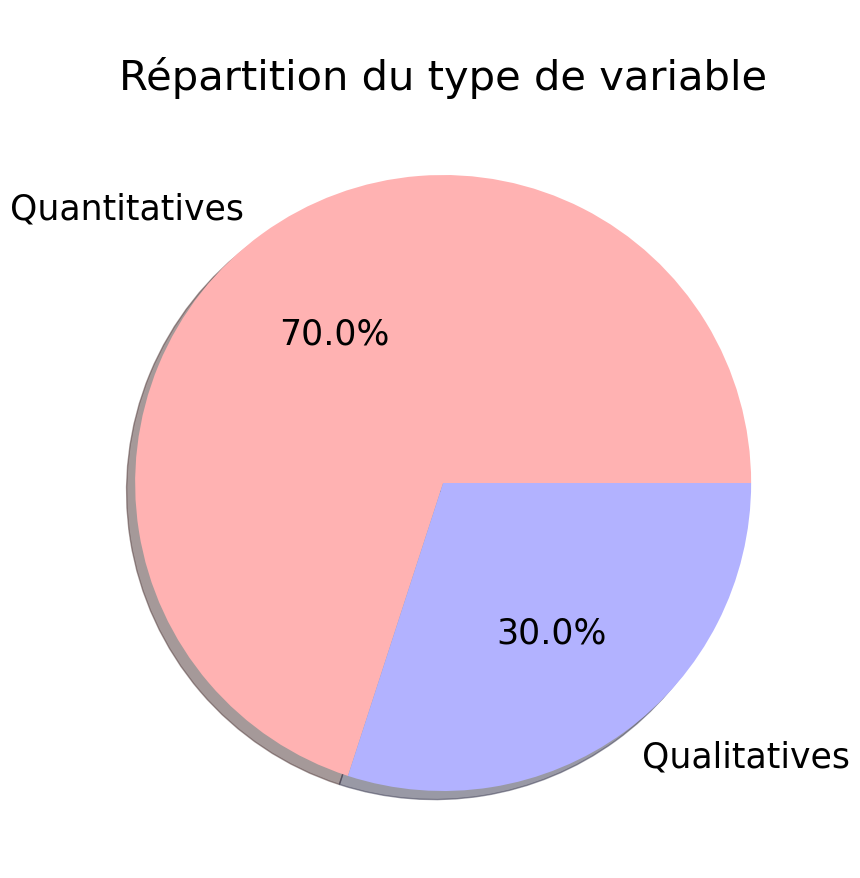

Variables quantitatives : 7
Variables qualitatives : 3
Total des variables : 10


In [20]:
filling_level(dataset=data_clean)

# **Exploration du dataset**

### **Matrice de corrélation (variables quantitatives)**

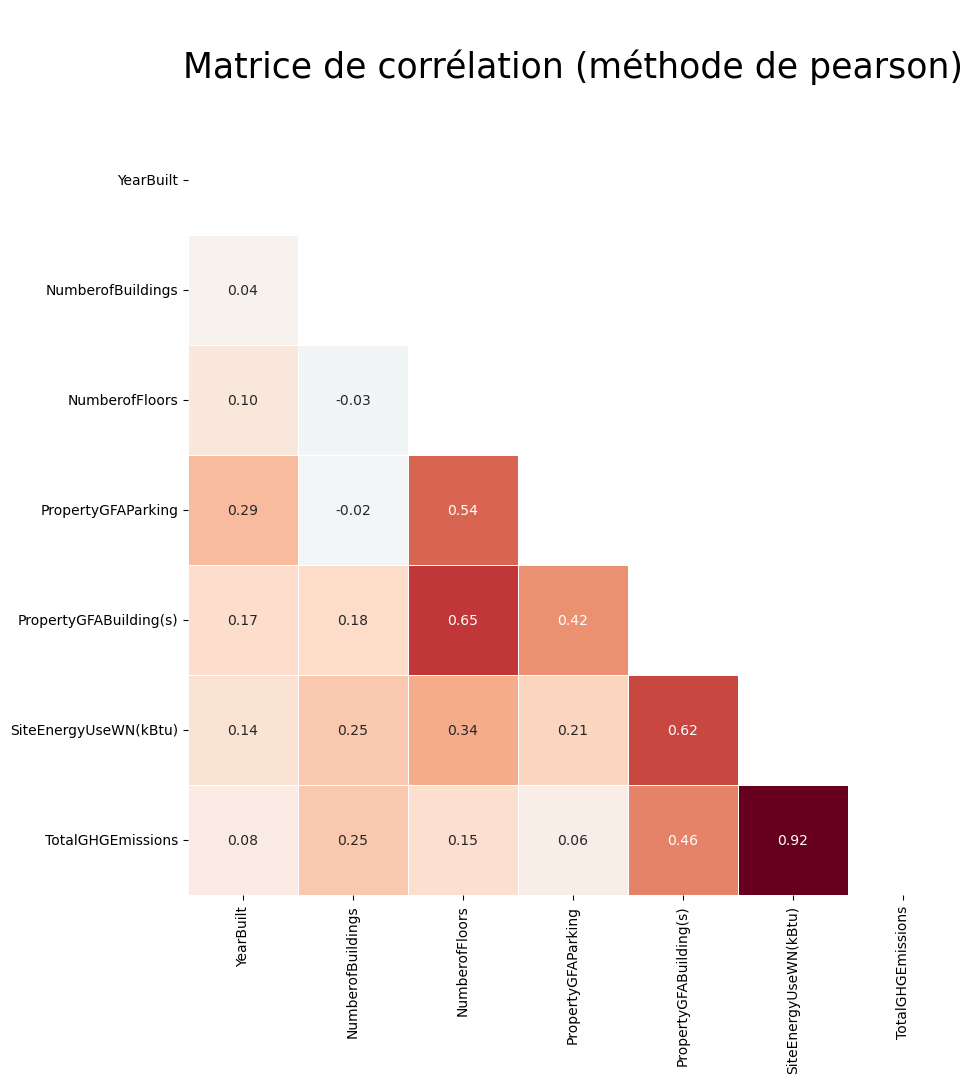

In [21]:
correlation = data_clean.corr(numeric_only = True, method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool), 0)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation, mask=mask, cbar = False, center=0, cmap='RdBu_r', annot=True, annot_kws={"size": 10}, fmt='.2f', square=True, linewidths=0.5).set_title('\nMatrice de corrélation (méthode de pearson)\n', fontsize=25)
plt.show()

In [22]:
def numeric_summary(discrete=False, discrete_xticks=False, showfliers=True, **kwargs):

    if data.empty == True:
        print("Vous devez indiquer une source de donnée valide (variable unique avec double crochets)")
        return


    # Description simple : 
    display(data.describe())


    # Différents indicateurs statistiques : 
    print("Moyenne :", round(float(data.mean().values), 2))
    print("Médiane :", round(float(data.median().values), 2))
    print("Mode(s) :", round(float(data.mode().values), 2))
    print("Variance :", round(float(data.var(ddof=0).values), 2))
    print("Écart type :", round(float(data.std(ddof=0).values), 2))
    print("Skew :", round(float(data.skew().values), 2))
    print("Kurtosis :", round(float(data.kurtosis().values), 2))


    # Histogramme : 

    if discrete == True:
        # Pour faire le même nombre de bins qu'on a de valeurs (discrètes) de la variable
        # np.arange(min, max, pas)
        bins = np.arange(data.values.min(), data.values.max()+1, 1)
        data.hist(color = "#8181FF", edgecolor='black', linewidth=0.5, bins=bins-0.5) # color = "blue", edgecolor='black', alpha = 0.3
        if discrete_xticks == True:
            plt.xticks(bins)
    else:
        data.hist(color = "#8181FF", linewidth=0.5, edgecolor='black', bins=20) # color = "blue", edgecolor='black', alpha = 0.3
    
    plt.grid(alpha = 0.8, ls=':')
    plt.title(f"\n{data.columns[0]}\n", fontsize=20)
    plt.show()


    # Boîte à moustaches :

    param_box_plot =  {
             'patch_artist': True,
             'boxprops': dict(linestyle='-', linewidth=1, color='black', facecolor='#8181FF'),
             'capprops': dict(color='black', linewidth=2),
             'flierprops': dict(color='#8181FF', markeredgecolor='black', markeredgewidth=0.5, markerfacecolor='#8181FF', markersize=15, marker='.', alpha=.1),
             'medianprops': dict(linestyle='-', linewidth=2, color='#ED3B23'),
             'meanprops': dict(marker='o', markeredgecolor='black', markeredgewidth=1, markerfacecolor='#ED3B23'),
             'whiskerprops': dict(color='black', linewidth=2)
                      }
    
    data.boxplot(vert=False, color = "#8181FF", showfliers=showfliers, showmeans=True, **param_box_plot).set(ylabel=None)
    
    if showfliers == False:
        outliers_titre = "\n(outliers masqués)"
    else:
        outliers_titre = ""

    plt.grid(alpha = 0.8, ls=':')
    plt.yticks([]) 
    plt.title(f"\n{data.columns[0]}{outliers_titre}\n", fontsize=20)
    plt.show()

In [23]:
data_clean.select_dtypes(include=np.number)

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,1927,1,12,0,88434,7.456910e+06,249.98
1,1996,1,11,15064,88502,8.664479e+06,295.86
2,1969,1,41,196718,759392,7.393711e+07,2089.28
3,1926,1,10,0,61320,6.946800e+06,286.43
4,1980,1,18,62000,113580,1.465650e+07,505.01
...,...,...,...,...,...,...,...
3370,1982,1,1,0,18261,1.025432e+06,20.33
3372,2004,1,1,0,16000,1.053706e+06,32.17
3373,1974,1,1,0,13157,6.053764e+06,223.54
3374,1989,1,1,0,14101,7.828413e+05,22.11


,NumberofBuildings
count,1535.0
mean,1.142671
std,1.18546
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,27.0


Moyenne : 1.14
Médiane : 1.0
Mode(s) : 1.0
Variance : 1.4
Écart type : 1.19
Skew : 14.11
Kurtosis : 248.55


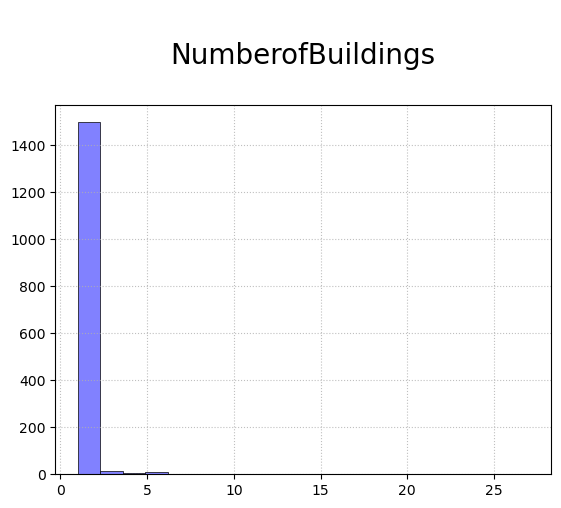

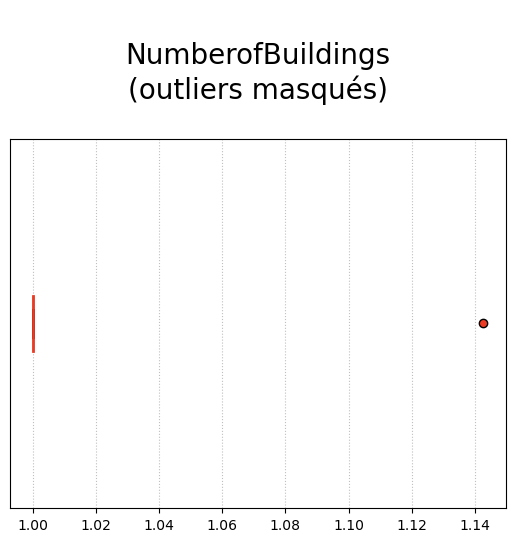

In [24]:
data=data_clean[['NumberofBuildings']]

numeric_summary(data=data, discrete=False, discrete_xticks=False, showfliers=False)